In [42]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix, roc_curve, auc

# import handcalcs.render
from matplotlib.dates import MonthLocator, DayLocator

In [43]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)

train_results = pd.read_csv('result/ml_train_results.csv', index_col=0)
test_results = pd.read_csv('result/ml_test_results.csv',  index_col=0)

proba_svm = np.loadtxt('result/svm_proba.csv', delimiter=',')
proba_rf = np.loadtxt('result/rf_proba.csv', delimiter=',')
proba_xgb = np.loadtxt('result/xgb_proba.csv', delimiter=',')
probas = [proba_svm, proba_rf, proba_xgb]

feature_importance = pd.read_csv('result/feature_importance.csv', index_col=0)
feature_importance.feature = ['Week', r'$\mu^c$', r'$\beta^c$', r'$Policy^c$', r'$Delta^c$',r'$Omicron^c$', r'$Policy^p$',r'$\sigma^c$']

time_line = pd.read_excel('data/time_line.xlsx')

train['train'] = 1
test['train'] = 0

case = pd.read_excel('temp/number1.xlsx')
RI = pd.read_excel('temp/number2.xlsx')

ml_train = pd.read_csv('result/ml_train_results.csv', index_col=0)
ml_test = pd.read_csv('result/ml_test_results.csv',  index_col=0)
ml_data = pd.concat([ml_train,ml_test])

data = pd.concat([train,test])
result_data = pd.concat([data,ml_data[['svm','rf','xgb']]],axis=1)
result_data.sort_values('data_num',inplace=True)
result_data.reset_index(drop=True, inplace=True)
result_data = pd.concat([result_data,RI], axis=1)

In [44]:
def plot_confusion_matrix(cm, method, cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    tick_marks = np.arange(3)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()).astype(str))

    plt.title(method)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    label_names = ['L0', 'L1', 'L2']
    plt.xticks([0,1,2], labels=label_names)
    plt.yticks([0,1,2], labels=label_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

machine_name = ['SVM', 'RF', 'XGB']

cm_svm = confusion_matrix(test_results.Label, test_results.svm)
cm_rf = confusion_matrix(test_results.Label, test_results.rf)
cm_xgb= confusion_matrix(test_results.Label, test_results.xgb)

cms = [cm_svm, cm_rf, cm_xgb]

---
# Figure 3

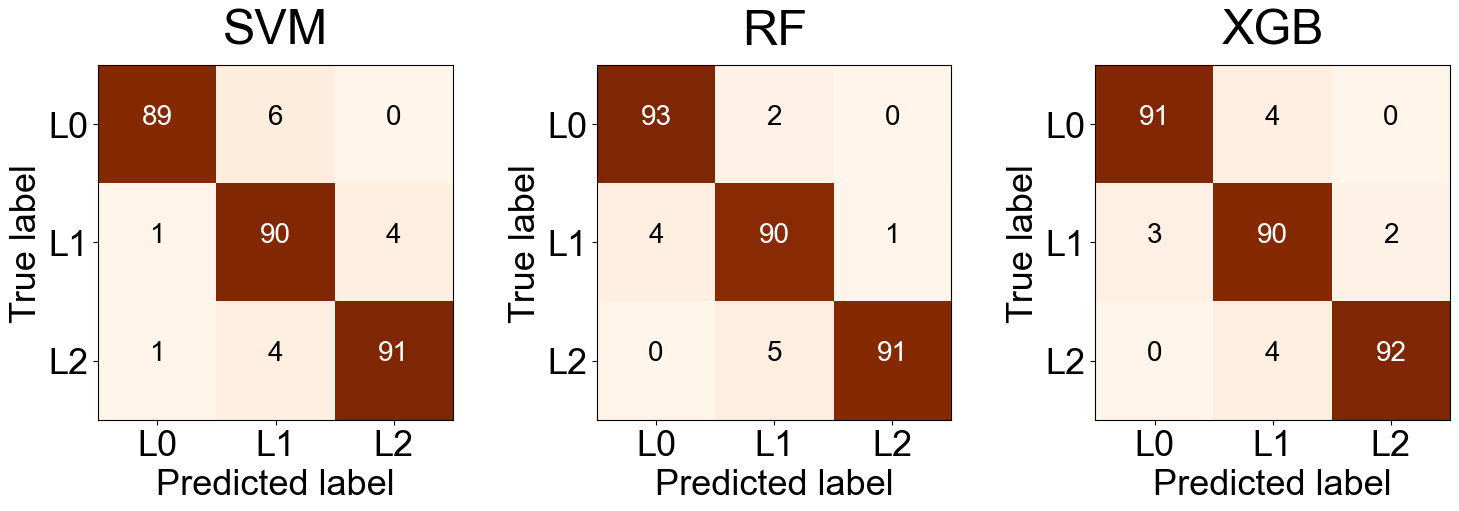

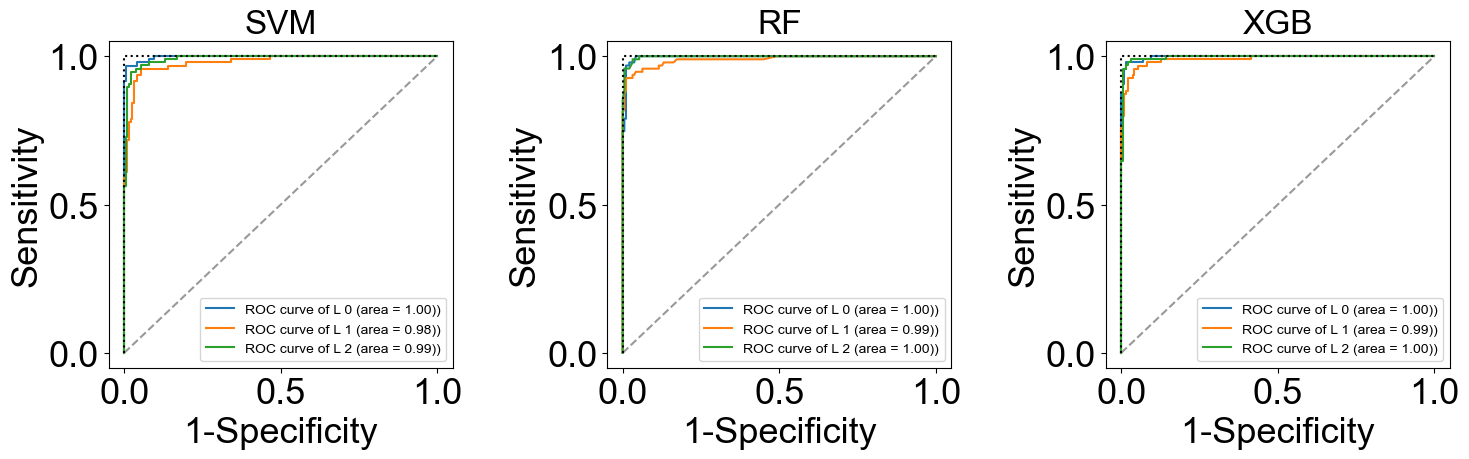

In [45]:
plt.figure(figsize=(15,10))
grid_s = gridspec.GridSpec(1,3)
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Arial'

for idx, method in enumerate(machine_name):
    ax = plt.subplot(grid_s[idx])
    plot_confusion_matrix(cms[idx],method)
    plt.title(machine_name[idx], fontsize=35, pad=15)
    title_font = {'fontname':'Arial'}
    plt.tight_layout(w_pad=2)

plt.rc('legend', fontsize=10)  

plt.figure(figsize=(15,5))
grid_s = gridspec.GridSpec(1,3)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for idx, method in enumerate(machine_name):
    ax = plt.subplot(grid_s[idx])

    for i in range(3):
        proba = probas[idx][:,i]
        fpr, tpr, _ = roc_curve(test.Label, proba, pos_label=i)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label='ROC curve of L {0:0d} (area = {1:0.2f}))'.format(i,roc_auc))

    plt.plot([0,1],[0,1], linestyle='--', color=(0.6, 0.6, 0.6))
    plt.plot([0,0,1],[0,1,1], linestyle=':', color='black')
    plt.legend(loc='lower right')
    plt.yticks([0.0,0.5,1.0])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title(method)

plt.tight_layout(w_pad=2)
plt.show()    

---
# Figure 4

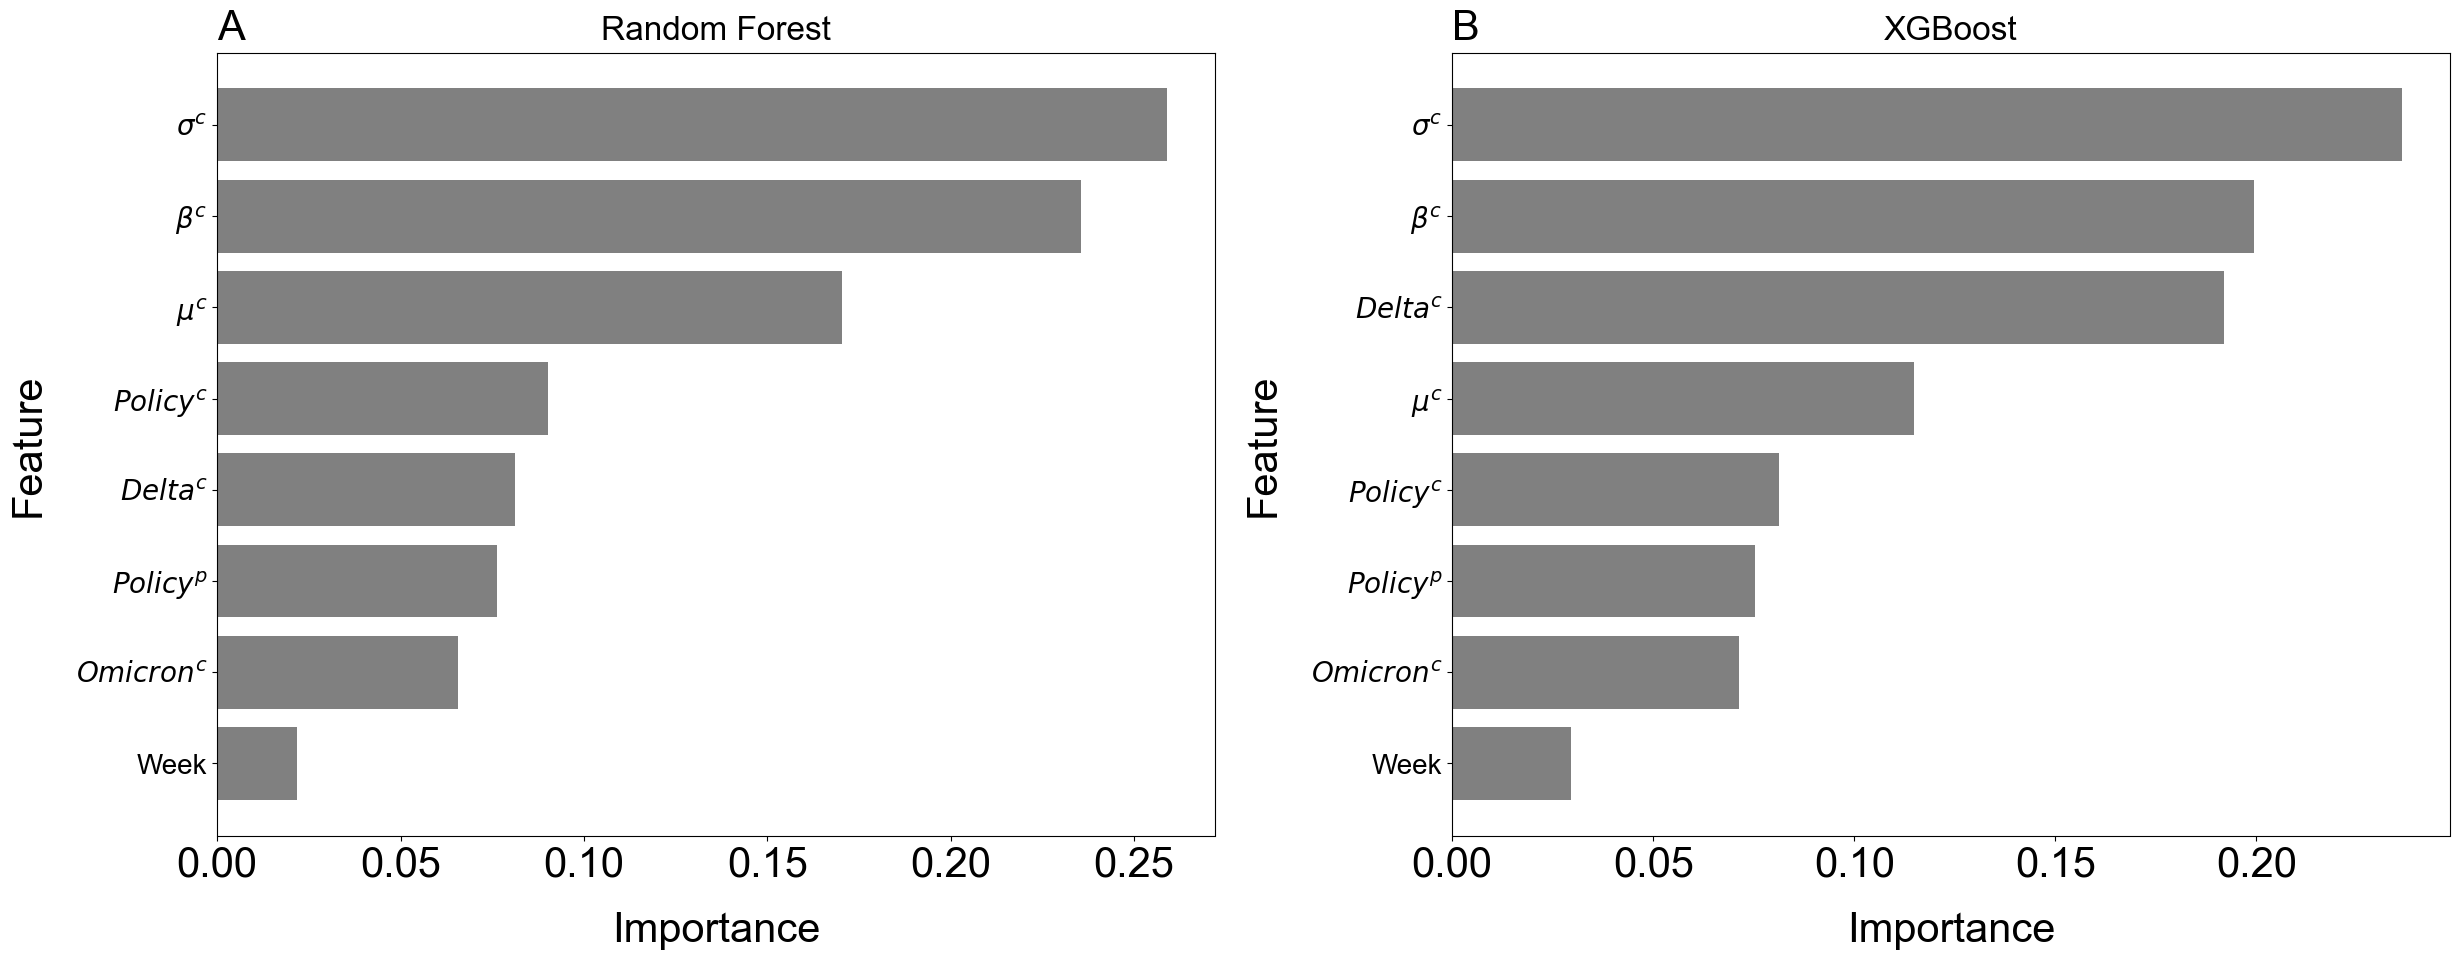

In [46]:
fig = plt.figure(figsize=(25,10))
grid_s = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(grid_s[0, 0])
ax2 = fig.add_subplot(grid_s[0, 1])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

title_font = {'fontname':'Arial'}
plt.rcParams['font.family'] = 'Arial'

for idx, method in enumerate(['RF','XGB']):
    ax = plt.subplot(grid_s[idx])

    feature_importance.sort_values(by=[method],ascending=True,inplace=True)
    pos = np.arange(feature_importance.feature.shape[0]) + .5
    plt.barh(pos, feature_importance[method], align='center', color='grey')
    plt.yticks(pos, feature_importance.feature, fontsize=20) 
    plt.xticks(fontsize=30)
    plt.xlabel('Importance', fontsize=30, labelpad=20)   #labelpad
    plt.ylabel('Feature', fontsize=30, labelpad=20)

    ax1.set_title("Random Forest", pad=30)
    ax1.set_title("A", loc='left', pad=10, fontsize=30)
    ax2.set_title("XGBoost", pad=30)
    ax2.set_title("B", loc='left', pad=10, fontsize=30)
plt.tight_layout()
plt.show()

---
# Figure 5

In [47]:
row_start_svm = []
row_end_svm = []
for i in range(len(result_data)):
    if result_data.loc[i,'svm']==2:
        if result_data.loc[i-1,'svm']!=2:
            row_start_svm.append(result_data.index[i])
            
for i in range(len(result_data)-1):
    if result_data.loc[i+1,'svm']!=2:
        if result_data.loc[i,'svm']==2:
            row_end_svm.append(result_data.index[i])
            
row_start_svm.append(result_data[result_data['svm']==2].tail(1).index[0])

row_2_svm=[]
for i in range(len(row_start_svm)-1):
    if row_start_svm[i+1]-row_start_svm[i]>14:
        if row_end_svm[i]-row_start_svm[i]>14:
            row_2_svm.append(row_start_svm[i])


row_start_rf = []
row_end_rf = []
for i in range(len(result_data)):
    if result_data.loc[i,'rf']==2:
        if result_data.loc[i-1,'rf']!=2:
            row_start_rf.append(result_data.index[i])
            
for i in range(len(result_data)-1):
    if result_data.loc[i+1,'rf']!=2:
        if result_data.loc[i,'rf']==2:
            row_end_rf.append(result_data.index[i])
            
row_start_rf.append(result_data[result_data['rf']==2].tail(1).index[0])

row_2_rf=[]
for i in range(len(row_start_rf)-1):
    if row_start_rf[i+1]-row_start_rf[i]>14:
        if row_end_rf[i]-row_start_rf[i]>14:
            row_2_rf.append(row_start_rf[i])

row_start_xgb = []
row_end_xgb = []
for i in range(1,len(result_data)):
    if result_data.loc[i,'xgb']==2:
        if result_data.loc[i-1,'xgb']!=2:
            row_start_xgb.append(result_data.index[i])
            
for i in range(1,len(result_data)-1):
    if result_data.loc[i+1,'xgb']!=2:
        if result_data.loc[i,'xgb']==2:
            row_end_xgb.append(result_data.index[i])
            
row_start_xgb.append(result_data[result_data['xgb']==2].tail(1).index[0])

row_2_xgb=[]
for i in range(len(row_start_xgb)-1):
    if row_start_xgb[i+1]-row_start_xgb[i]>14:
        if row_end_xgb[i]-row_start_xgb[i]>14:
            row_2_xgb.append(row_start_xgb[i])

label2_line = result_data.loc[result_data['Label']==2,'RI'].min()
label1_line = result_data.loc[result_data['Label']==1,'RI'].min()
label0_line = result_data.loc[result_data['Label']==0,'RI'].min()

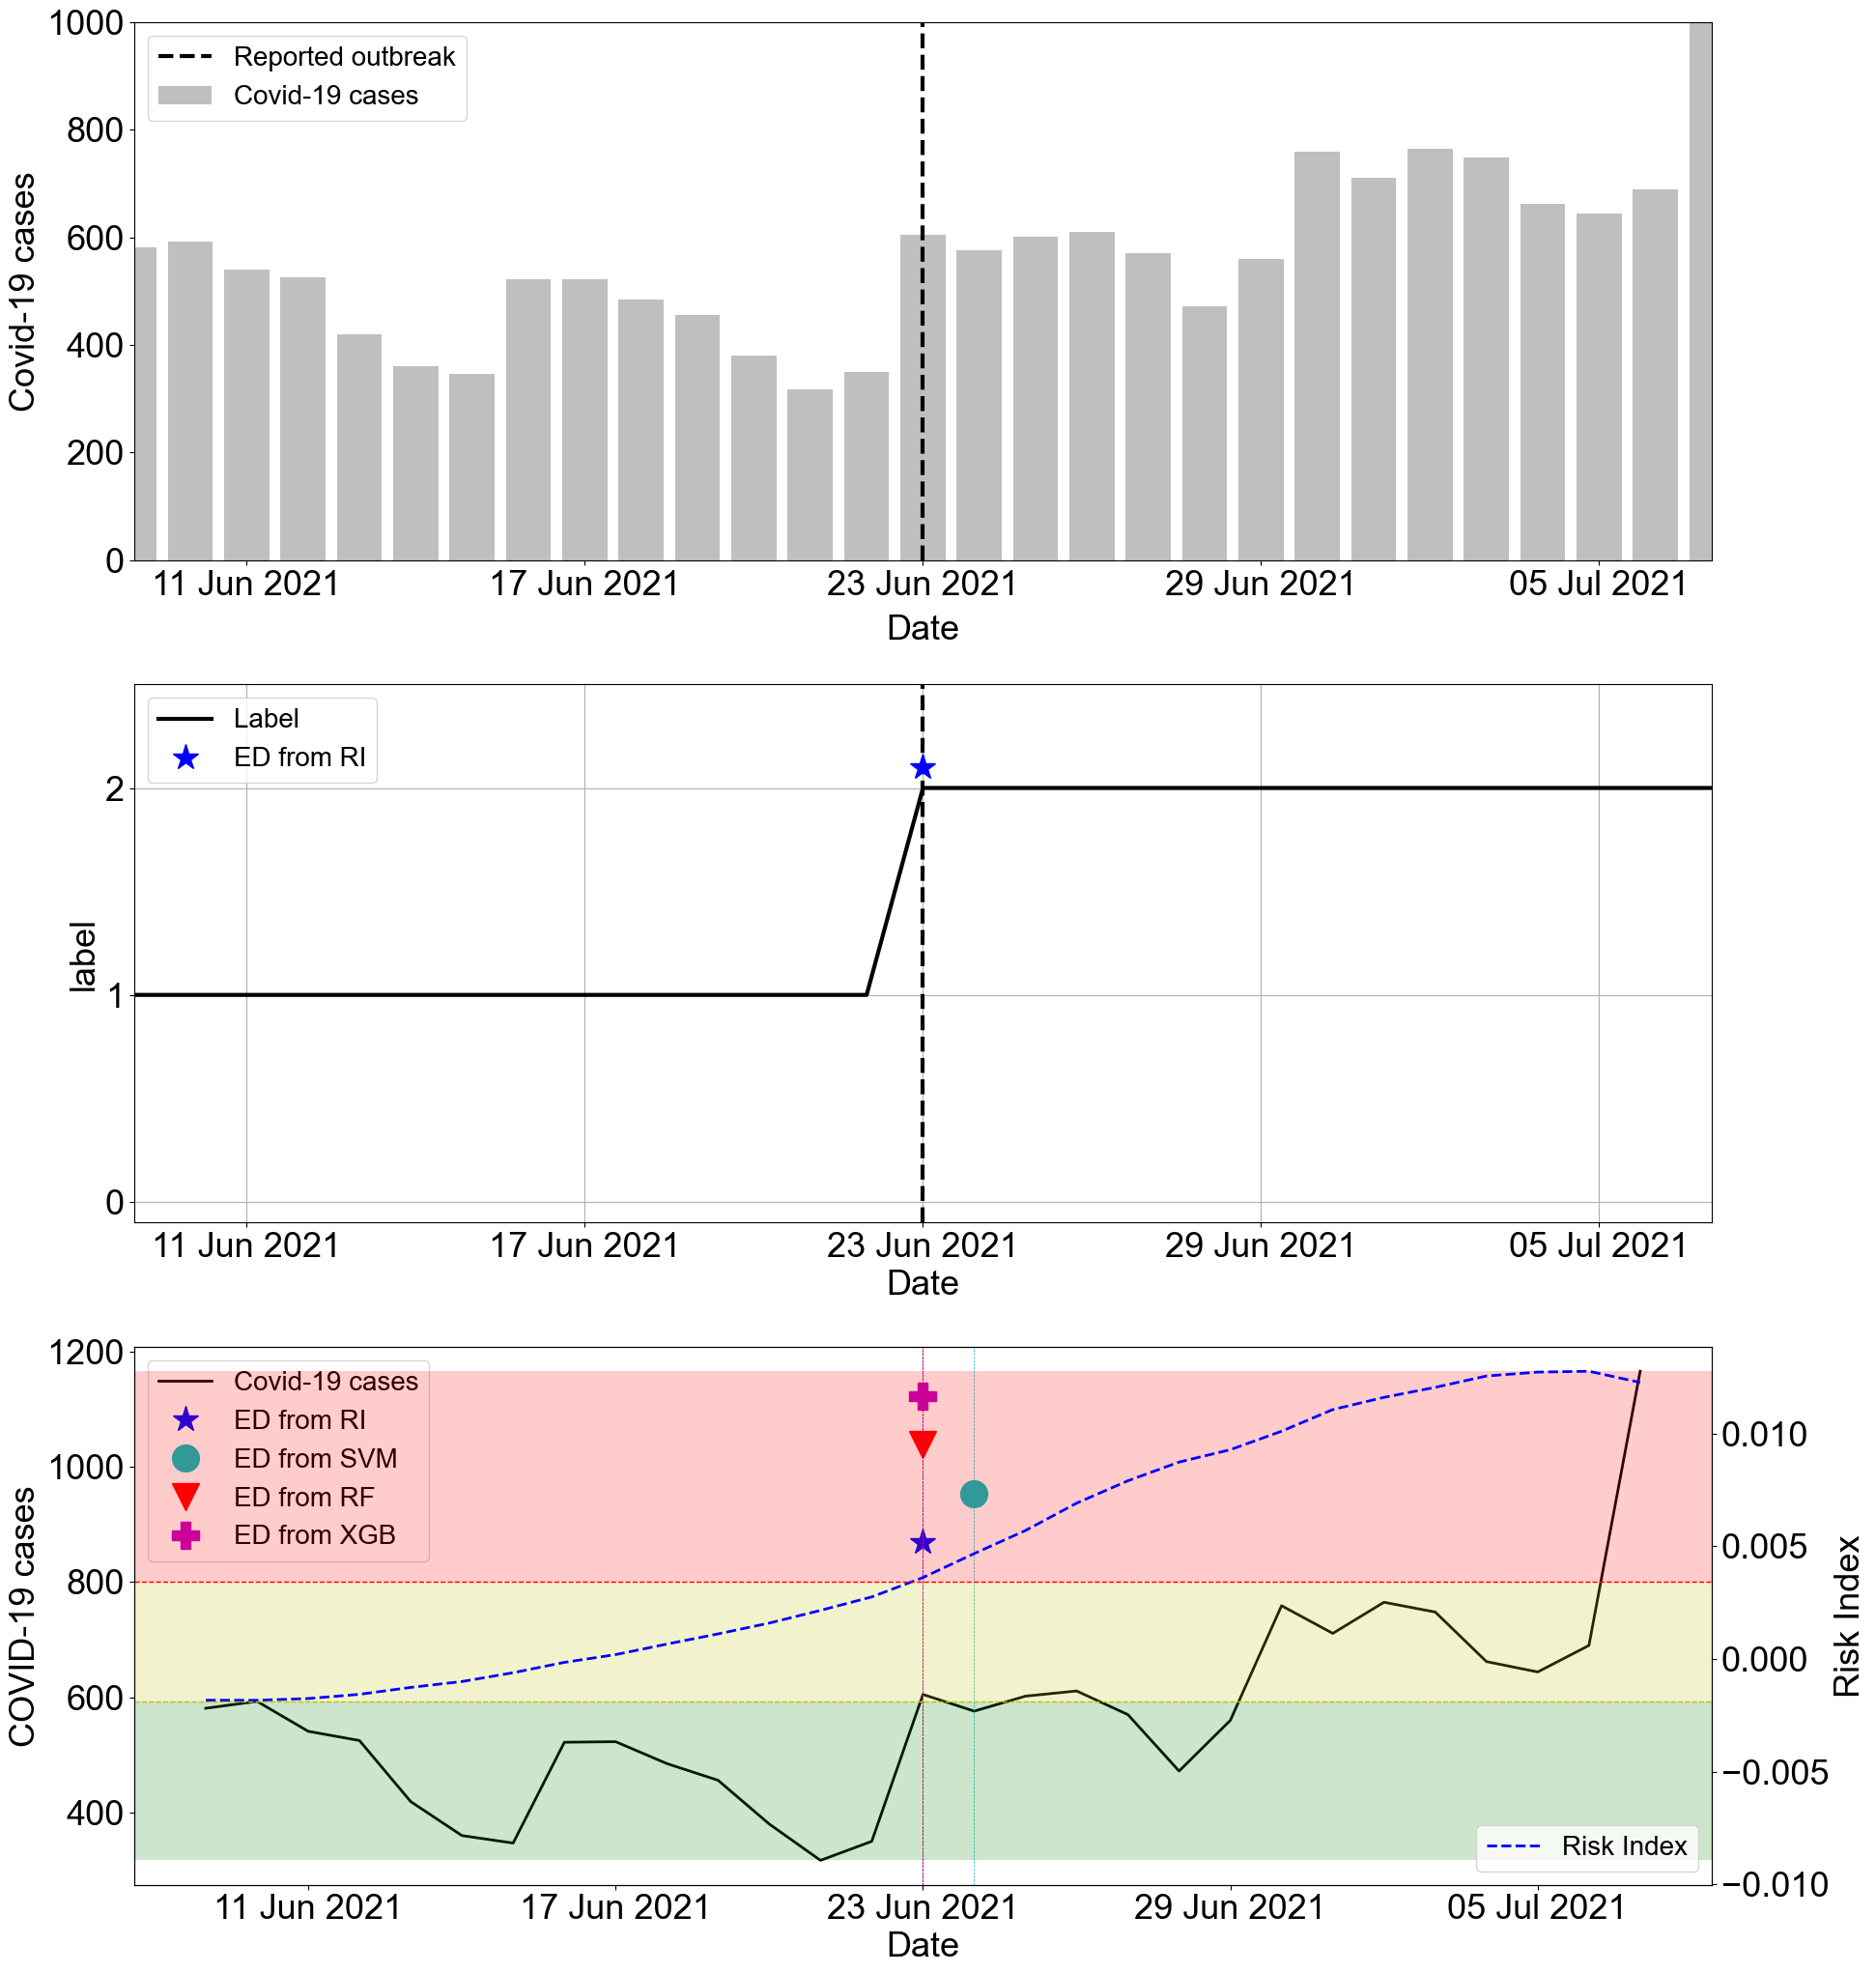

In [48]:
result_prob = pd.DataFrame()
early_time = []
lot = 3
sub_num = 20
time_interval = 14

row_start = []
row_end = []
for i in range(len(result_data)):
    if result_data.loc[i,'Label']==2:
        if result_data.loc[i-1,'Label']!=2:
            row_start.append(result_data.index[i])
            
for i in range(len(result_data)-1):
    if result_data.loc[i+1,'Label']!=2:
        if result_data.loc[i,'Label']==2:
            row_end.append(result_data.index[i])
            
row_start.append(result_data[result_data['Label']==2].tail(1).index[0])

row_2=[]
for i in range(len(row_start)-1):
    if row_start[i+1]-row_start[i]>14:
        if row_end[i]-row_start[i]>14:
            row_2.append(row_start[i])

plt.rc('font', size=26)        
plt.rc('axes', labelsize=26)  
plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=26)  
plt.rc('legend', fontsize=20)  
plt.rc('figure', titlesize=26)


plt.figure(figsize=(20,21))
grid_s = gridspec.GridSpec(3,1)
plt.subplots_adjust(wspace=0.3, hspace=0.2)

x=range(len(case))
y=case['number']
ax = plt.subplot(grid_s[0])
        
temp_start = row_2[3]+sub_num-14
temp_end = row_2[3]+sub_num+14    
plt.bar(range(temp_start,temp_end+1),case.loc[temp_start:temp_end,'number'],color='gray',alpha=0.5, label='Covid-19 cases')
plt.axvline(time_line['start_time'][2],color='k',linestyle='--',linewidth=3, label='Reported outbreak')
plt.xlim([477,505])
plt.ylim([-0.1, 1000])
xlabels = case.date.loc[477:505].dt.strftime('%d %b %Y').to_list()
plt.xticks(case.idx[477:506], xlabels)
ax.xaxis.set_major_locator(DayLocator(interval=6))
plt.xlabel('Date',labelpad=10)
plt.ylabel('Covid-19 cases')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
plt.tight_layout()

ax = plt.subplot(grid_s[1])
plt.plot(result_data['data_num']+sub_num,result_data['Label'],color='k',linewidth=3, label='Label')
plt.axvline(time_line['start_time'][2],color='k',linestyle='--',linewidth=3)

i=3    
temp_start = row_2[i]+sub_num-time_interval
temp_end = row_2[i]+sub_num+time_interval
result_prob.loc[lot,'season'] = str(i+1)
    
temp_train = result_data[(result_data['data_num']>=temp_start-sub_num) & (result_data['data_num']<=temp_end-sub_num) & (result_data['train']==1)]
temp_test = result_data[(result_data['data_num']>=temp_start-sub_num) & (result_data['data_num']<=temp_end-sub_num) & (result_data['train']==0)]
result_prob.loc[lot,'train_num'] = len(temp_train)
result_prob.loc[lot,'test_num'] = len(temp_test)
result_prob.loc[lot,'TT_rate'] = len(temp_test)/(len(temp_train)+len(temp_test))
        
plt.plot(row_2+sub_num*np.ones(len(row_2)),2.1*np.ones(len(row_2)),'*',color='b',markersize=20, label='ED from RI')
plt.xlim([477,505])
plt.ylim([-0.1, 2.5])
plt.yticks([0, 1, 2])
xlabels = case.date.loc[477:505].dt.strftime('%d %b %Y').to_list()
plt.xticks(case.idx[477:506], xlabels)
ax.xaxis.set_major_locator(DayLocator(interval=6))

plt.xlabel('Date')
plt.ylabel('label')
plt.tight_layout(pad=3)
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
plt.tight_layout()

ax = plt.subplot(grid_s[2])
i=3
temp_start = row_2[i]+sub_num-14
temp_end = row_2[i]+sub_num+14    
    
ax.plot(range(temp_start,temp_end+1), case.loc[temp_start:temp_end,'number'],'k',linewidth=2,label='Covid-19 cases')
    
temp_y1 = case.loc[temp_start:temp_end,'number'].min()+0.65*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
temp_y2 = case.loc[temp_start:temp_end,'number'].min()+0.75*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
temp_y3 = case.loc[temp_start:temp_end,'number'].min()+0.85*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
temp_y4 = case.loc[temp_start:temp_end,'number'].min()+0.95*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
    
ax.plot(row_2[i]+sub_num,temp_y1,'*',color='b',markersize=20, label='ED from RI')
ax.plot(row_2_svm[i]+sub_num,temp_y2,'o',color='c',markersize=20, label='ED from SVM')
ax.plot(row_2_rf[i]+sub_num,temp_y3,'v',color='r',markersize=20, label='ED from RF')
ax.plot(row_2_xgb[i]+sub_num,temp_y4,'P',color='m',markersize=20, label='ED from XGB')
    
ax.axvline(row_2[i]+sub_num,color='b',linestyle='--',linewidth=0.5)
ax.axvline(row_2_svm[i]+sub_num,color='c',linestyle='--',linewidth=0.5)
ax.axvline(row_2_rf[i]+sub_num,color='r',linestyle='--',linewidth=0.5)
ax.axvline(row_2_xgb[i]+sub_num,color='m',linestyle='--',linewidth=0.5)    
    
ax.set_xlabel('Date', fontsize=26)
ax.set_ylabel('COVID-19 cases', fontsize=26)
    
xlabels = case.date.dt.strftime('%d %b %Y').to_list()
plt.xticks(case.idx, xlabels)
ax.xaxis.set_major_locator(DayLocator(interval=6))
    
ax2 = ax.twinx()
ax2.plot(range(temp_start,temp_end+1), result_data.loc[temp_start-sub_num:temp_end-sub_num,'RI'],'--b',linewidth=2,label='Risk Index')
ax2.axhline(label2_line,color='r',linestyle='--',linewidth=1)
ax2.axhline(label1_line,color='y',linestyle='--',linewidth=1)

ax2.axhspan(label0_line,label1_line,facecolor='g',alpha=0.2)
ax2.axhspan(label1_line,label2_line,facecolor='y',alpha=0.2)
ax2.axhspan(label2_line,result_data.loc[temp_start-sub_num:temp_end-sub_num,'RI'].max(),facecolor='r',alpha=0.2)
ax2.set_ylabel('Risk Index')

ax.legend(loc='upper left', bbox_to_anchor=(0, 1.0))
ax2.legend(loc='lower right')
    
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
    
plt.tight_layout()
plt.show()

---
# Figure 6


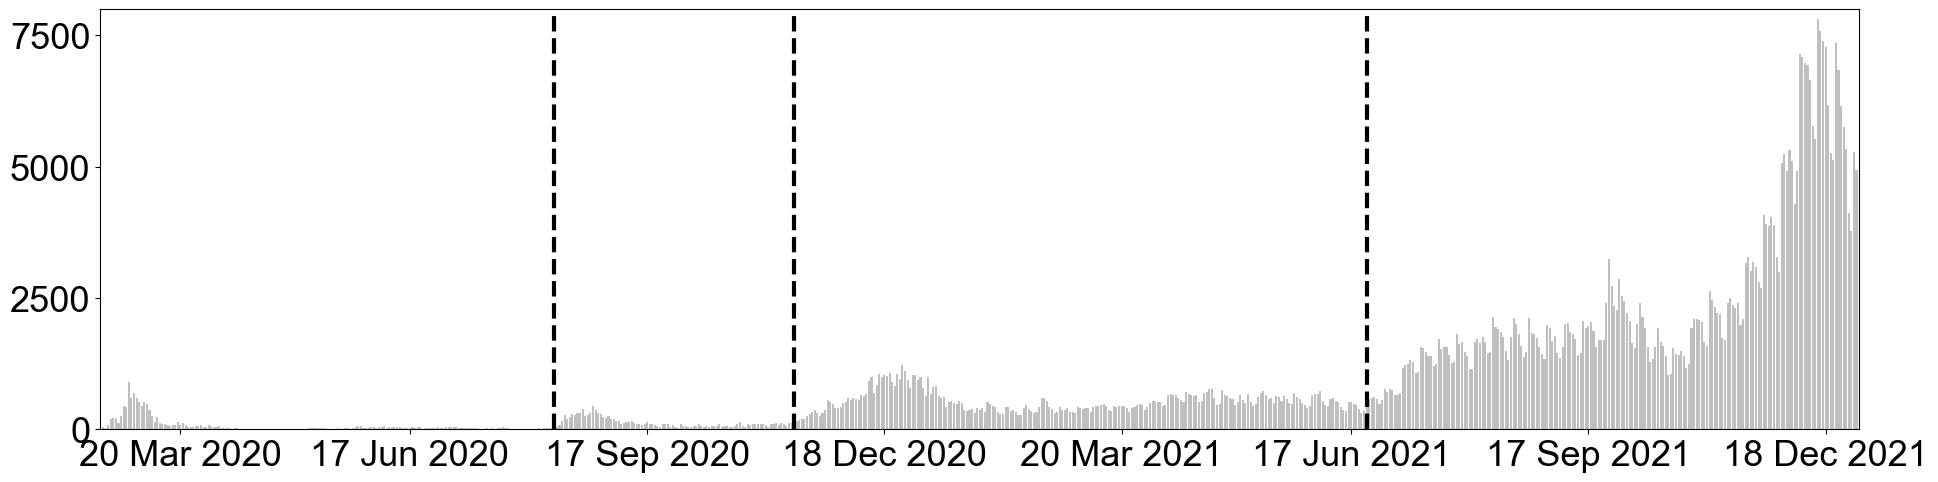

In [49]:
plt.figure(figsize=(20,10))
grid_s = gridspec.GridSpec(2,1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

x=range(len(case[0:682]))
y=case[0:682]['number']

ax = plt.subplot(grid_s[0])
plt.bar(x,y,color='gray',alpha=0.5, label='Covid-19 cases')
for i in range(3):
    if i==0:
        plt.axvline(time_line['start_time'][i],color='k',linestyle='--',linewidth=3)
    else:
        plt.axvline(time_line['start_time'][i],color='k',linestyle='--',linewidth=3)

plt.xlim([-0.1, 682])
xlabels = case[0:682].date.dt.strftime('%d %b %Y').to_list()
plt.xticks(case[0:682].idx, xlabels)
plt.yticks([0,2500,5000,7500])
ax.xaxis.set_major_locator(MonthLocator(interval=3))
plt.xlim([-0.1, 682])
plt.ylim([0,8000])
plt.tight_layout()
plt.show()

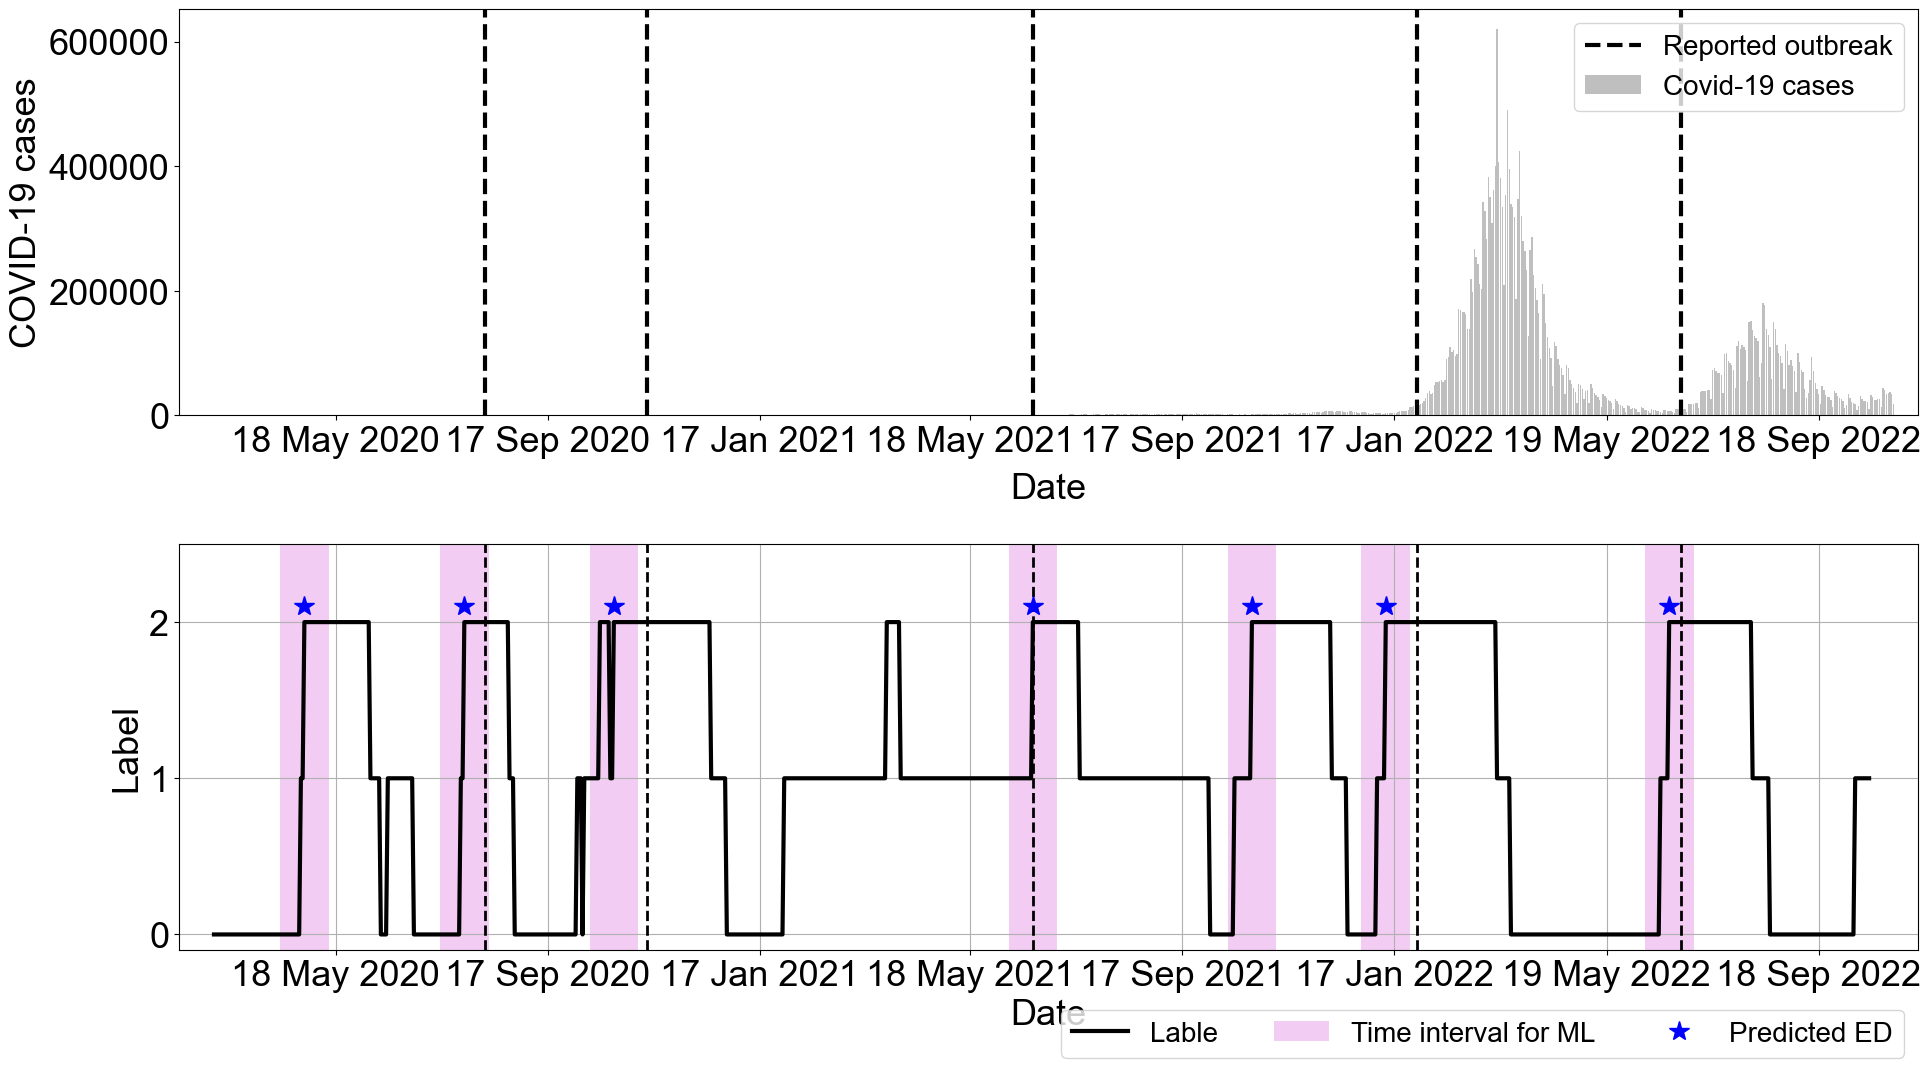

In [50]:
machine_method = ['svm', 'rf', 'xgb']
result_prob = pd.DataFrame()
early_time = []
lot = 0
sub_num = 20
time_interval = 14
row_start = []
row_end = []
for i in range(len(result_data)):
    if result_data.loc[i,'Label']==2:
        if result_data.loc[i-1,'Label']!=2:
            row_start.append(result_data.index[i])

for i in range(len(result_data)-1):
    if result_data.loc[i+1,'Label']!=2:
        if result_data.loc[i,'Label']==2:
            row_end.append(result_data.index[i])
            
row_start.append(result_data[result_data['Label']==2].tail(1).index[0])

row_2=[]
for i in range(len(row_start)-1):
    if row_start[i+1]-row_start[i]>14:
        if row_end[i]-row_start[i]>14:
            row_2.append(row_start[i])

plt.figure(figsize=(20,11))
grid_s = gridspec.GridSpec(2,1)
plt.subplots_adjust(wspace=0.3, hspace=0.5)


x=range(len(case))
y=case['number']

ax = plt.subplot(grid_s[0])
plt.bar(x,y,color='gray',alpha=0.5, label='Covid-19 cases')
for i in range(5):
    if i==0:
        plt.axvline(time_line['start_time'][i],color='k',linestyle='--',linewidth=3, label='Reported outbreak')
    else:
        plt.axvline(time_line['start_time'][i],color='k',linestyle='--',linewidth=3)

plt.xlim([-0.1, 1000])
plt.yticks([0, 200000,400000, 600000])

xlabels = case.date.dt.strftime('%d %b %Y').to_list()
plt.xticks(case.idx, xlabels)
ax.xaxis.set_major_locator(MonthLocator(interval=4))

plt.xlabel('Date',labelpad=10)
plt.ylabel('COVID-19 cases')
plt.legend()

ax = plt.subplot(grid_s[1])
plt.plot(result_data['data_num']+sub_num,result_data['Label'],color='k',linewidth=3, label='Lable')

for i in range(5):
    plt.axvline(time_line['start_time'][i],color='k',linestyle='--',linewidth=2)
for i in range(len(row_2)):    
    temp_start = row_2[i]+sub_num-time_interval
    temp_end = row_2[i]+sub_num+time_interval    
    result_prob.loc[lot,'season'] = str(i+1)
    
    temp_train = result_data[(result_data['data_num']>=temp_start-sub_num) & (result_data['data_num']<=temp_end-sub_num) & (result_data['train']==1)]
    temp_test = result_data[(result_data['data_num']>=temp_start-sub_num) & (result_data['data_num']<=temp_end-sub_num) & (result_data['train']==0)]
    result_prob.loc[lot,'train_num'] = len(temp_train)
    result_prob.loc[lot,'test_num'] = len(temp_test)    
    result_prob.loc[lot,'TT_rate'] = len(temp_test)/(len(temp_train)+len(temp_test))

    if i==1:
        plt.axvspan(temp_start,temp_end,facecolor='m',alpha=0.2, label='Time interval for ML')
    else:
        plt.axvspan(temp_start,temp_end,facecolor='m',alpha=0.2)
    for j in machine_method:
        result_prob.loc[lot,j+'_train']=len(temp_train[temp_train['Label']==temp_train[j]])/len(temp_train)
        result_prob.loc[lot,j+'_test']=len(temp_test[temp_test['Label']==temp_test[j]])/len(temp_test)
    early_time.append(temp_test[(temp_test['Label']==2) & (temp_test['Label']==temp_test['rf'])]['data_num'].values[0]+sub_num)    
    lot = lot+1
    
plt.plot(row_2+sub_num*np.ones(len(row_2)),2.1*np.ones(len(row_2)),'*',color='b',markersize=15, label='Predicted ED')
xlabels = case.date.dt.strftime('%d %b %Y').to_list()
plt.xticks(case.idx, xlabels)
ax.xaxis.set_major_locator(MonthLocator(interval=4))
plt.xlim([-0.1, 1000])
plt.ylim([-0.1, 2.5])
plt.yticks([0, 1, 2])

plt.xlabel('Date')
plt.ylabel('Label')
plt.tight_layout()
plt.grid(True)
plt.legend(loc='lower right', ncol=3, bbox_to_anchor=(1, -0.3))

plt.show()

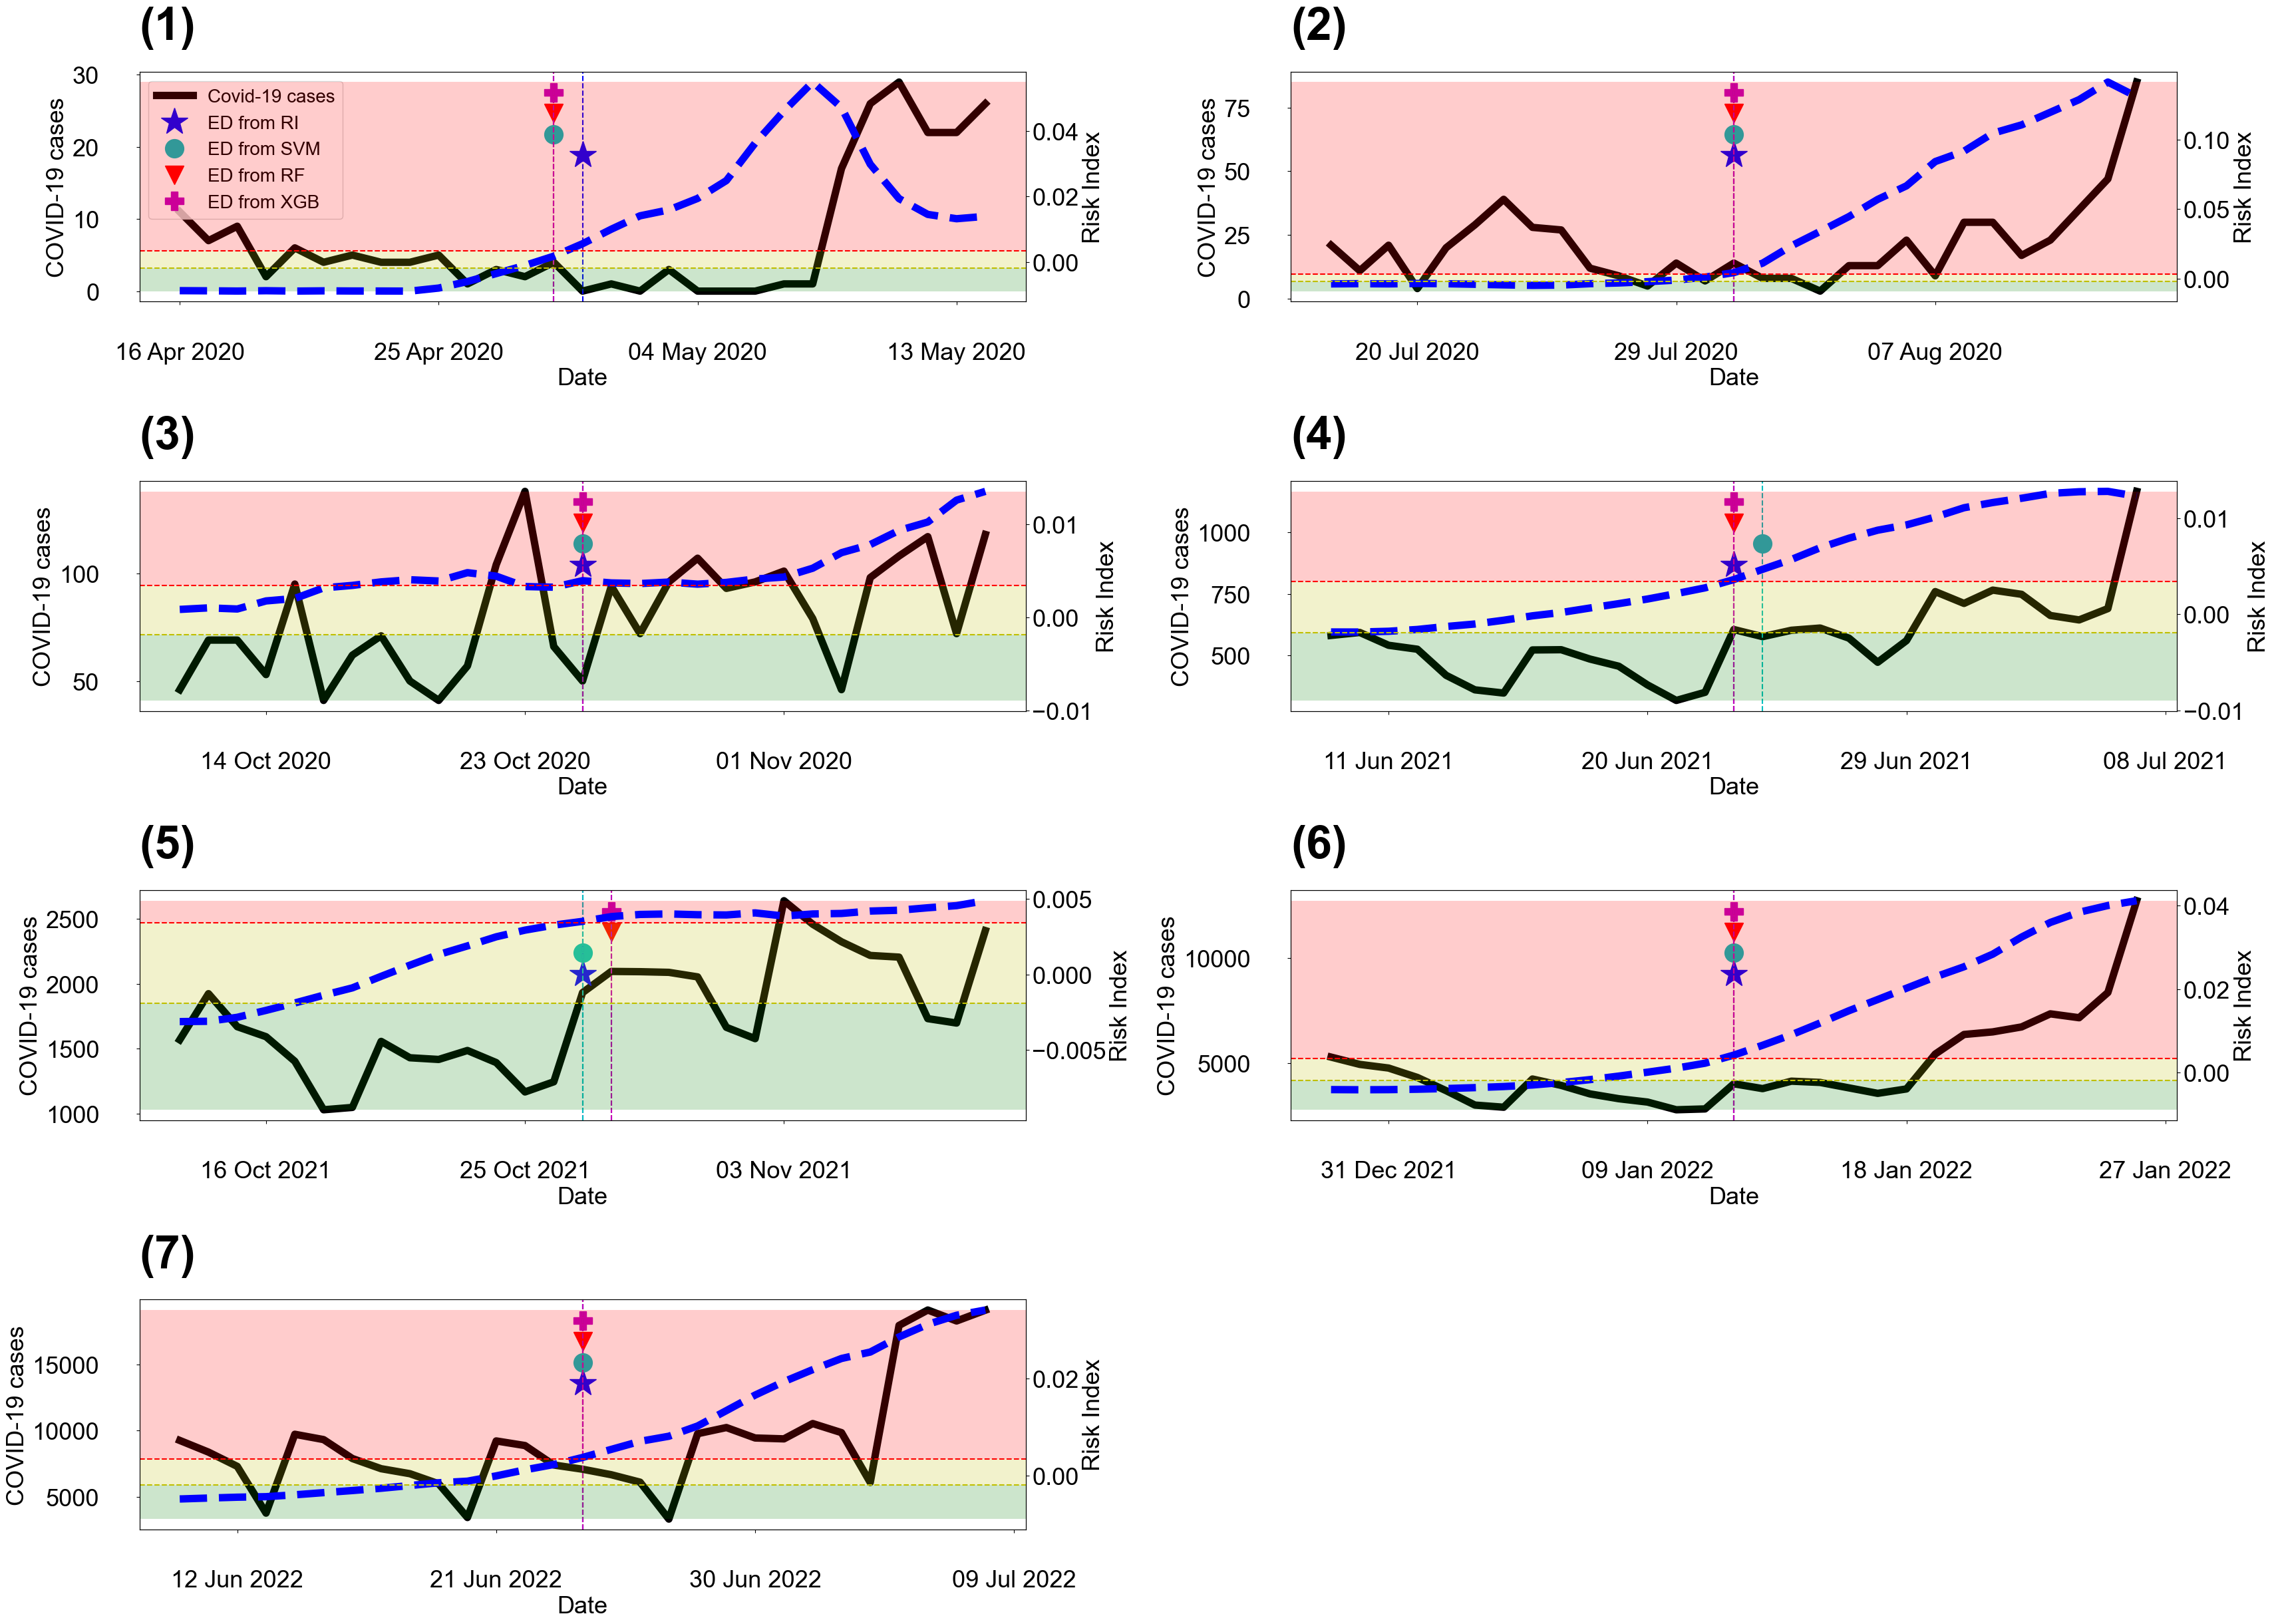

In [51]:
plt.figure(figsize=(35,25))
grid_s = gridspec.GridSpec(4,2)

plt.subplots_adjust(wspace=0, hspace=0)

ax0= plt.subplot(grid_s[0])
ax0.set_title("(1)", loc="left", fontsize=50, fontweight="bold", pad=35)
ax1= plt.subplot(grid_s[1])
ax1.set_title("(2)", loc="left", fontsize=50, fontweight="bold", pad=35)
ax2= plt.subplot(grid_s[2])
ax2.set_title("(3)", loc="left", fontsize=50, fontweight="bold", pad=35)
ax3= plt.subplot(grid_s[3])
ax3.set_title("(4)", loc="left", fontsize=50, fontweight="bold", pad=35)
ax4= plt.subplot(grid_s[4])
ax4.set_title("(5)", loc="left", fontsize=50,fontweight="bold", pad=35)
ax5= plt.subplot(grid_s[5])
ax5.set_title("(6)", loc="left", fontsize=50,fontweight="bold", pad=35)
ax6= plt.subplot(grid_s[6])
ax6.set_title("(7)", loc="left",fontsize=50, fontweight="bold", pad=35)

for i in range(len(row_2)):
    ax = plt.subplot(grid_s[i])
    temp_start = row_2[i]+sub_num-time_interval
    temp_end = row_2[i]+sub_num+time_interval
    
    ax.plot(range(temp_start,temp_end+1), case.loc[temp_start:temp_end,'number'],'k',linewidth=8,label='Covid-19 cases')

    temp_y1 = case.loc[temp_start:temp_end,'number'].min()+0.65*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
    temp_y2 = case.loc[temp_start:temp_end,'number'].min()+0.75*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
    temp_y3 = case.loc[temp_start:temp_end,'number'].min()+0.85*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
    temp_y4 = case.loc[temp_start:temp_end,'number'].min()+0.95*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
    
    ax.plot(row_2[i]+sub_num,temp_y1,'*',color='b',markersize=30, label='ED from RI')
    ax.plot(row_2_svm[i]+sub_num,temp_y2,'o',color='c',markersize=20, label='ED from SVM')
    ax.plot(row_2_rf[i]+sub_num,temp_y3,'v',color='r',markersize=20, label='ED from RF')
    ax.plot(row_2_xgb[i]+sub_num,temp_y4,'P',color='m',markersize=20, label='ED from XGB')
    
    ax.axvline(row_2[i]+sub_num,color='b',linestyle='--',linewidth=1.5)
    ax.axvline(row_2_svm[i]+sub_num,color='c',linestyle='--',linewidth=1.5)
    ax.axvline(row_2_rf[i]+sub_num,color='r',linestyle='--',linewidth=1.5)
    ax.axvline(row_2_xgb[i]+sub_num,color='m',linestyle='--',linewidth=1.5)    
    
    ax.set_xlabel('Date') 
    ax.set_ylabel('COVID-19 cases')

    ax.tick_params(pad=40)
    xlabels = case.date.dt.strftime('%d %b %Y').to_list()
    plt.xticks(case.idx, xlabels)
    ax.xaxis.set_major_locator(DayLocator(interval=9))
    
    ax2 = ax.twinx()
    ax2.plot(range(temp_start,temp_end+1), result_data.loc[temp_start-sub_num:temp_end-sub_num,'RI'],'--b',linewidth=8,label='RI')
    ax2.axhline(label2_line,color='r',linestyle='--',linewidth=1.5,label='Label 2')
    ax2.axhline(label1_line,color='y',linestyle='--',linewidth=1.5,label='Label 1')
    
    
    ax2.axhspan(label0_line,label1_line,facecolor='g',alpha=0.2)
    ax2.axhspan(label1_line,label2_line,facecolor='y',alpha=0.2)
    ax2.axhspan(label2_line,result_data.loc[temp_start-sub_num:temp_end-sub_num,'RI'].max(),facecolor='r',alpha=0.2)
    
    ax2.set_ylabel('Risk Index')
    if i==0:
        ax.legend(loc='upper left', bbox_to_anchor=(0, 1.0))
    
plt.tight_layout()
plt.show()